In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time 
import seaborn as sns
import re
import json
import shapely.geometry as sg
#import osmnx as ox
#import tabula
import geopandas as gpd
from shapely import Point, MultiPolygon 
from shapely.ops import triangulate
import random

/home/zaki/Desktop/H/beytic/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Clean the data

## Read the data

In [3]:
df = pd.read_csv("sale_apartments_05_11_2023.csv")
#df.sample(2)

/tmp/ipykernel_7009/1148631862.py:1: DtypeWarning: Columns (9,14,16,17,18,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sale_apartments_05_11_2023.csv")


## Read the Address df 

In [4]:
gmap_2 = pd.read_csv('sale_apartments_gmap_addresses.csv',usecols=['request_id','query','data_7','coordinate'])

## Transform the column 'prdx_desc', to str type

In [5]:
df['prdx_desc'] = df['prdx_desc'].astype(str)

## Keep only the rows after 2018

In [6]:
# Keep only the anouces after 2018
df['year'] = df['prdx_created_at'].astype(str).str.slice(0,4).astype(int)
df = df[df['year'] >= 2018]

## Iterate throught all choices (returned by google) 

In [7]:
import pandas as pd
import numpy as np
from rank_bm25 import BM25Okapi

# Function to compute BM25 ranking and return the most similar document's text

def get_most_similar_text_bm25(query, documents):
    # Ensure all documents are strings
    documents = [str(doc) for doc in documents]

    # Tokenize the documents
    tokenized_docs = [doc.split(" ") for doc in documents]
    bm25 = BM25Okapi(tokenized_docs)
    
    # Tokenize the query
    tokenized_query = query.split(" ")
    
    # Get scores for the query against the documents
    doc_scores = bm25.get_scores(tokenized_query)
    
    # Get the index of the highest score
    most_similar_doc_index = np.argmax(doc_scores)
    
    # Return the actual document text that is the best match
    return documents[most_similar_doc_index]

# Add a 'geo' and 'best match' column to df
df['geo'] = None
df['best match'] = None
df['adr_address_01'] = df['adr_address_01'].astype(str)
df['cty_name'] =df['cty_name'].astype(str)
df['stt_name'] = df['stt_name'].astype(str)

# Iterate over df

for idx, row in df.iterrows():
    match = row['adr_address_01'] + ', ' + row['cty_name'] + ', ' + row['stt_name']
    if (match is None) or pd.isna(row['address_request_id']):
        df.at[idx, 'geo'] = np.nan
        continue
    
    filtered_gmap_2 = gmap_2[gmap_2['request_id'] == row['address_request_id']]
    
    if len(filtered_gmap_2) == 1:
        df.at[idx, 'geo'] = filtered_gmap_2['coordinate'].iloc[0]
    elif len(filtered_gmap_2) > 1:
        most_similar_text = get_most_similar_text_bm25(match, filtered_gmap_2['data_7'].tolist())
        matching_rows = filtered_gmap_2[filtered_gmap_2['data_7'] == most_similar_text]
        
        # Check if there is at least one matching row
        if not matching_rows.empty:
            match_row = matching_rows.iloc[0]
            df.at[idx, 'geo'] = match_row['coordinate']
            df.at[idx, 'best match'] = most_similar_text
        else:
            # Handle the case where no matching row is found
            df.at[idx, 'geo'] = np.nan
            df.at[idx, 'best match'] = "No match found"

# At this point, df will have two new columns: 'geo' and 'best match'


## Imput the values of adr_latitude and adr_longitude, with adr_latitude and adr_longitude of the chosen address

In [8]:
for idx, row in df.iterrows():
    if not pd.isna(row['geo']):
        row['adr_latitude'] = row['geo'][0]
        row['adr_longitude'] = row['geo'][1]

## Drop the not used columns

In [9]:
# drop unwanted columns
df.drop(columns=['Unnamed: 0','prdx_name','prdx_ouedkniss_id','anc_price_type',
'prdx_accept_exchange','prdx_price_unit','prdx_price_preview','prdx_view_number','prdx_likes_number', 'type','property_payment_conditions'
, 'sale_by_real_estate_agent','prdx_created_at','best match','geo'], inplace = True)

## Drop the rows that contain more than one apartment

In [10]:
# drop the rows that contain more than one apartment

# Function to extract apartment patterns from the description
def extract_apartment_patterns(text):
    if isinstance(text, str):
        patterns = re.findall(r'\bf[ \-_]?[\d]{1,2}\b', text, flags=re.IGNORECASE)
        return patterns
    else:
        return []

df['rooms'] = df['prdx_desc'].apply(extract_apartment_patterns)

# Function to determine which rows should be dropped based on the provided criteria
def should_drop_with_regex(description, patterns):
    keyword_pattern = r"\b(?:transform|modif|amenag|aménag)\b"
    contains_keywords = re.search(keyword_pattern, description, flags=re.IGNORECASE)
    
    if len(patterns) == 2 and contains_keywords:
        return False
    elif len(patterns) >= 2:
        return True
    else:
        return False

df['drop_with_regex'] = df.apply(lambda row: should_drop_with_regex(str(row['prdx_desc']).lower(), row['rooms']), axis=1)

# Remove the rows that meet the criteria for dropping
df = df[~df['drop_with_regex']]
df.reset_index(drop=True, inplace=True)

# drop unwanted columns
df.drop(columns=['drop_with_regex'], inplace = True)

/tmp/ipykernel_7009/3920668793.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['drop_with_regex'], inplace = True)


In [11]:
# clean the rooms column
# transform lists to floats
df['rooms'] = df['rooms'].apply(lambda x: x[0] if len(x) == 1 else np.nan )

/tmp/ipykernel_7009/1585163280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rooms'] = df['rooms'].apply(lambda x: x[0] if len(x) == 1 else np.nan )


### Extract the size of teh apartment from the description.

In [12]:
def extract_largest_area_refined(description):
    try:
        # Initialize variables
        largest_area = 0

        # If the description is not a string, return 0
        if not isinstance(description, str):
            return 0

        # Replace newline and carriage return characters
        description = description.replace('\n', ' ').replace('\r', ' ').strip()

        # Define regular expression patterns to find area in various formats
        area_patterns = [
            r'(\d+[\.,]?\d*)\s*m[²2]',  # 300m2, 108.m2, 200 m²
          #  r'(\d+[\.,]?\d*)\s*m',      # 480 m
            r'(\d+[\.,]?\d*)\s*sqm',    # 200 sqm
            r'(\d+[\.,]?\d*)\s*²',      # 175²
            r'(\d+[\.,]?\d*)\s*m[èeé]tres?\s*au\s*carr[éeé]',  # 152 metres au carre
            r'(\d+[\.,]?\d*)\s*m[èeé]tres?\s*carr[éeés]',      # 120 metre carrés, 155metre carré
            r'قدرها\s*(\d+[\.,]?\d*)\s*متر',  # مساحة قدرها 385 متر
            r'\s*(\d+[\.,]?\d*)\s*متر²',
            r'\s*(\d+[\.,]?\d*)\s*مترًا مربعًا',
            r'\s*(\d+[\.,]?\d*)\s*متر مربع',
            r'\s*(\d+[\.,]?\d*)\s*م مربع',
            r'\s*(\d+[\.,]?\d*)\s*م²',  # المساحة الكلية : 190 م²
            r'\s*(\d+[\.,]?\d*)\s*م2',
            r'مساحة\s*(\d+[\.,]?\d*)',  # 
            #r'(\d+[\.,]?\d*)\s*metres?'  # 497metres
        ]

        # Search for all area matches
        for pattern in area_patterns:
            area_matches = re.findall(pattern, description, re.IGNORECASE)
            for area_match in area_matches:
                area = float(area_match.replace(',', '.'))
                largest_area = max(largest_area, area)

        return largest_area
    except Exception as e:
        return np.nan

# Apply the extract_area function to create a new column
df['size'] = df['prdx_desc'].apply(extract_largest_area_refined)

# Fill missing values in "superficie" with values from the new column
df['superficie'].fillna(df['size'], inplace=True)


In [13]:
# Drop the missing values of superficie, and greatre than 400, lower than 20
df = df.dropna(subset=['superficie'])
df['superficie'] = pd.to_numeric(df['superficie'], errors='coerce')
df = df[(df['superficie'] <= 400) & (df['superficie'] >= 20)]

### Get if the apartment has equiped kitchen

In [14]:
search_words = ['cuisine équip',"cuisine equip",'cuisine am','cuisine fonctio','cuisine meubl','cuisine tou', 'cuisine toute','مطبخ كامل','مطبخ مجهز']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['kitchen'] = df['prdx_desc'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)

### Get if the apartment has central heating

In [15]:
search_words = ['chaudi',"chod",'chauffage central','chauffage au sol','radiateur','تدفئة مركزية','تدفئة أرضية']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['heating'] = df['prdx_desc'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)

### Get if the apartment is in a promotion

In [16]:
search_words = ['promotion',"résidence",'securise','residence','ترقية','إقامة','اقامة']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['promotion'] = df['prdx_desc'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)

In [17]:
df['asset_in_promotional_site'] = df['asset_in_promotional_site'].astype(float)

In [18]:
# fill the missing values of the column 'asset_in_promotional_site' with the values of the column 'promotion'.
df['asset_in_promotional_site'].fillna(df['promotion'], inplace=True)


# Drop the temporary "extracted_area" column if no longer needed
df.drop(columns=['promotion'], inplace=True)

In [19]:
"""# Create a mapping dictionary
promotion_mapping = {True: 1, False: 0}

# Replace values in the 'asset_in_promotional_site' column using the mapping
df['asset_in_promotional_site'] = df['asset_in_promotional_site'].replace(promotion_mapping)"""

"# Create a mapping dictionary\npromotion_mapping = {True: 1, False: 0}\n\n# Replace values in the 'asset_in_promotional_site' column using the mapping\ndf['asset_in_promotional_site'] = df['asset_in_promotional_site'].replace(promotion_mapping)"

### Get if the apartment is secured

In [20]:
search_words = ['sécurisé',"sécurise",'securise','gardien','clôturée','clôtur','clotur','surveillance','contrôlé','controlé','contrôle','controle','أمن'
                ,'حراسة','مغلق','حارس']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['secured'] = df['prdx_desc'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)

### Get if the apartment has a parking.

In [21]:
"""search_words = ['Garage']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['parking'] = df['property_specifications'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)"""

"search_words = ['Garage']\n\n# Create a new column 'garden' with 1 if any search word is found, otherwise 0\ndf['parking'] = df['property_specifications'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)"

In [22]:
# create a list of words to check
#stationnement|box|parking|voiture|garage|سيارات|باركينغ|مرآب|جراج|ركن
words = ['box', 'garage','جراج','مرآب'] # 'parking', 'voiture','باركينغ','سيارات'

# join the words with a logical OR
pattern = '|'.join(words)

# check if the 'prdx_desc' column contains any of the words
mask = df['prdx_desc'].str.contains(pattern, case=False,regex=True)
df.loc[mask, 'parking'] = 1
df['parking'] = df['parking'].fillna(0)

### Get if the apartment has agrden

In [23]:
# Words to search for

search_words = ['garden', 'jar']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['garden'] = df['property_specifications'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)

In [24]:
# create a list of words to check
words = ['حديقة صغيرة', 'حديقة خاصة', 'Terrasse', 'Cours priv', 'Loggia', 'veronda', 'jard']

# join the words with a logical OR
pattern = '|'.join(words)

# check if the 'prdx_desc' column contains any of the words
mask = df['prdx_desc'].str.contains(pattern, case=False,regex=True)
# assign 1 to the 'garden' column where mask is True
df.loc[mask, 'garden'] = 1
df['garden'] = df['garden'].fillna(0)

### Get if the apartment is Fournished or not

In [25]:
# Words to search for

search_words = ['fournish', 'meubl']

# Create a new column 'garden' with 1 if any search word is found, otherwise 0
df['fournished'] = df['property_specifications'].str.contains('|'.join(search_words), case=False, regex=True).astype(float)

In [26]:
# create a list of words to check
words = ['Meublé moderne', 'Entièrement meublé', 'Entierement meublé', 'Entièrement meuble', 
'Entierement meuble','Aménagé','Aménage','Amenagé','Amenage','Prêt à vivre','مفروش','مجهزة كليا','جاهز للسكن','مهيأ']

# join the words with a logical OR
pattern = '|'.join(words)

# check if the 'prdx_desc' column contains any of the words
mask = df['prdx_desc'].str.contains(pattern, case=False,regex=True)
df.loc[mask, 'fournished'] = 1
df['fournished'] = df['fournished'].fillna(0)

### Get the papes

In [27]:
# Function to determine the value for the 'papers' column based on 'property_specifications'
def determine_paper_value(specifications):
    if pd.isna(specifications):
        return "No"
    
    acte_notarie = "Acte notarié" in specifications
    livret_foncier = "Livret foncier" in specifications
    promesse_vente = 'Promesse de vente possible' in specifications
    permi_construire = 'construire' in specifications

    if acte_notarie and livret_foncier:
        return "AL"    
    elif acte_notarie:
        return "A"
    else: return "No"    
    """elif livret_foncier:
        return "L"
    elif promesse_vente:
        return "P"
    elif permi_construire:
        return "C"    
    else:
        return "No"""

# Apply the function to the 'property_specifications' column to create the 'papers' column
df['ownership'] = df['property_specifications'].apply(determine_paper_value)

In [28]:
def determine_paper_english(specifications):
    if pd.isna(specifications):
        return "No"
    
    acte_notarie = "notarial-act" in specifications
    livret_foncier = "real-estate-booklet" in specifications
    promotion = 'real-estate-promotion' in specifications
    permi_construire = 'construction-autorisation' in specifications
    decision = "decision" in specifications
    papies_tembre = 'stamped-paper'  in specifications

    if acte_notarie and livret_foncier:
        return "AL"    
    elif acte_notarie:
        return "A"
    else: return 'No'    
    """elif livret_foncier:
        return "L"
    elif promotion:
        return "PR"
    elif permi_construire:
        return "C"
    elif decision:
        return "DC"
    elif papies_tembre:
        return "PT"            
    else:
        return "No" """

# Apply the function to the 'property_specifications' column to create the 'papers' column
df['ownership_2'] = df['papers'].apply(determine_paper_english)

# imput the No values from column ownership column with values from ownership_2
df['ownership'] = df['ownership'].mask(df['ownership'] == 'No', df['ownership_2'])

df.drop(columns=['ownership_2'], inplace = True)

### Define a custom mapping for ownwership

In [31]:
# Define the custom mapping for 'ownership'
ownership_mapping = {
    'AL': 0,
    'A': 1,
    'No': 2
}
# Apply label encoding using the custom mapping
df['ownership'] = df['ownership'].map(ownership_mapping)

### Clean the floor column

In [32]:
def get_etage_matching(etage):

    etages_matching = {
        'rez-de-chaussée': 0,
        'rez de chaussée': 0,
        'rdc': 0,
        'r.d.c': 0,
        'rez de chaussée': 0,
        'rez de chaussé': 0,
        'rez de chausse': 0,
        'rez-de-chaussée': 0,
        'rez-de-chaussée': 0,
        'rez de chausser': 0,
        'rez de chaussee': 0,
        'rez-de chaussée': 0,
        'rdc surélevé': 0,
        'rdc surelevé': 0,
        'rdc sureleve': 0,
        'rez-de-chaussée surélevé': 0,
        'rez-de-chaussée élevée': 0,
        'rdc sur élevé': 0,
        'rdc  surélevé': 0,
        'rue de chaussée': 0,
        'ritchosi': 0,
        'retchose': 0,
        'red chosè': 0,
        'red chose': 0,
        'red de chausse': 0,
        're de chausé': 0,
        'r chouci': 0,
        'r.d.chaussé': 0,
        'non elevé':2,
        'rc': 0,
        'rd': 0,
        'ارضي': 0,
        'أرضي': 0,
        'الأرضي': 0,
        'الارضي': 0,
        'الطابق الأرضي': 0,
        'طابق أرضي': 0,
        'الطابق الارضي': 0,
        'طابق ارضي': 0,
        'طابق الارضي': 0,
        'طابق الأرضي': 0,
        'rcd': 0,
        'rds': 0,
        'r+1':2,
        'sous sol':0,
        'طابقين':2,
        '2/6':2,
        '4/6':4,
        'rechausser':0,
        '1/6':1,
        'r+3':4,
        'أرضي(ريدشوسي)':0,
        'السفلي':0,
        'rch':0,
        '5/6':5,
        'Rez de chaussée surélevé':0,
        '3/4':3,
        'non élevé':1,
        'non elevé':2,

        '1er': 1,
        'الاول': 1,
        'لأول': 1,
        'الأول': 1,
        'الطابق الاول': 1,
        'طابق اول': 1,
        '1er étage': 1,
        '1 er étage': 1,
        '1etage': 1,
        '1 er': 1,
        '1 ere': 1,
        '1ere': 1,
        '1ère': 1,
        '1 étage': 1,
        '1 etage': 1,
        '1er etage': 1,
        '1ere etage': 1,
        '1ère étage': 1,
        '1ier étage ': 1,
        'premier': 1,
        'première étage': 1,
        'premier étage': 1,
        'R+1+TERRASSE':2,
        'الخامس5':5,
        'riz chausser':0,
        'r+2':3,
        
        'deuxième': 2,
        'deuxième étage': 2,
        'الثاني': 2,
        'طابق الثاني': 2,
        'الثانى': 2,
        'ثاني': 2,
        'الطابق الثاني': 2,
        'troisième': 3,
        'الثالث': 3,
        'الطابق الثالث': 3,
        'quatrième': 4,
        'quatrième (04) étage': 4,
        'الرابع': 4,
        'طابق الرابع': 4,
        'الطابق الرابع': 4,
        'الرابع (4)': 4,
        'الخامس': 5,
        'طابق خامس': 5,
        'السادس': 6,
        

    }

    if type(etage) == str:
        try:
            m = int(etage)
            return m
            print('etags', etage ,' ---- ', m)
        except Exception as e:
            # print('-->', etage)
            pass

        # print("ooozzz", etage.lower())
        matching = etages_matching.get(etage.lower(), None)
        # if etage == 'RDC':
        #     print('ooooooooooooo', matching)
        if matching is None:
            for index in range(2, 20):
                cases = [
                    f'{index}eme',
                    f'{index}ème',
                    f'{index}èmeétage',
                    f'{index}éme',
                    f'{index}-ème',
                    f'{index}emme',
                    f'{index}em',
                    f'{index}e',
                    f'{index}emeetage',
                    f'{index}emeétage',
                    f'{index}èmeetage',
                    f'{index}emetage',
                    f'{index}émeétage',
                    f'{index}ièmeetage'
                    f'{index}eétage ',
                    f'{index}etag',
                    f'{index}étage',
                    f'{index}etage',
                    f'{index}emeétage',
                    f'{index}assenseur',
                    f'{index}avecascenseur',
                    f'{index}ledernier'
                ]
                if etage.lower().replace(' ', '') in cases:
                    return index
        return matching if matching is not None else etage
    return etage

df['etages'] = df['etages'].apply(get_etage_matching)
# df = df.loc[(df['etages'].isin(range(0, 20)))]

In [33]:
def transform_etage(value):
     # Checking if the value is NaN or not a string
    if pd.isna(value) or isinstance(value, str):
        return '6'
    
    # Applying transformations based on the instructions
    if value in [0, 1]:
        return "1"
    elif value == 2:
        return "2"
    elif value == 3:
        return "3"
    elif value == 4:
        return "4"
    elif 5 <= value <= 20:
        return "5"
    else:
        return "6"

# Applying the transformation function to the 'etages' column
df['etages'] = df['etages'].apply(transform_etage)

## Clean the price .

In [34]:
def further_refined_extract_price(description):
    try:
        # Initialize variables
        highest_custom_price = 0
        found_price = False  # Flag to indicate if any price information was found

        # If the description is not a string, return 0
        if not isinstance(description, str):
            return 0

        # Replace newline and carriage return characters
        description = description.replace('\n', ' ').replace('\r', ' ').strip()

        # Define regular expression patterns
        milliards_pattern = r'(\d+[\.,]?\d*)?\s*(milliards?|ملايير|مليار|ملير|miliard|u)\s*(\d+[\.,]?\d*)?'
        millions_pattern = r'(\d+[\.,]?\d*)\s*(millions?|مليون|milion)'
        arabic_and_pattern = r'مليار\s*و\s*(\d+[\.,]?\d*)\s*مليون'
        arabic_complex_pattern = r'ماديلنا(\d+[\.,]?\d*)مليار'
        regular_price_pattern = r'(\d{1,3}(?:\.\d{3})*(?:,\d{2})?)\s*(DA|د ج)'
        special_price_pattern = r'(\d{1,3}(?:\.\d{3})*\.\d{2}(?:,\d{2})?)\s*(DA|د ج)'
        
        # Search for all milliards matches
        milliards_matches = re.findall(milliards_pattern, description, re.IGNORECASE)
        for milliards_match in milliards_matches:
            milliards_before = milliards_match[0]
            milliards_after = milliards_match[2]
            if milliards_before or milliards_after:
                found_price = True  # Found some price information
                milliards = 1 if not milliards_before else float(milliards_before.replace(',', '.'))
                millions = 0 if not milliards_after else float(milliards_after.replace(',', '.'))
                
                # Custom conversion
                custom_price = int(milliards * 10**7) + int(millions * 10**4)
                highest_custom_price = max(highest_custom_price, custom_price)

        # Search for all millions matches
        millions_matches = re.findall(millions_pattern, description, re.IGNORECASE)
        for millions_match in millions_matches:
            found_price = True  # Found some price information
            millions = float(millions_match[0].replace(',', '.'))
            
            # Custom conversion
            custom_price = int(millions * 10**4)
            highest_custom_price = max(highest_custom_price, custom_price)

        # Search for the complex Arabic pattern
        arabic_and_matches = re.findall(arabic_and_pattern, description, re.IGNORECASE)
        for arabic_and_match in arabic_and_matches:
            found_price = True  # Found some price information
            millions = float(arabic_and_match.replace(',', '.'))
            
            # Custom conversion
            custom_price = int(1 * 10**7) + int(millions * 10**4)
            highest_custom_price = max(highest_custom_price, custom_price)

        # Search for the additional complex Arabic pattern
        arabic_complex_matches = re.findall(arabic_complex_pattern, description, re.IGNORECASE)
        for arabic_complex_match in arabic_complex_matches:
            found_price = True  # Found some price information
            milliards = float(arabic_complex_match.replace(',', '.'))
            
            # Custom conversion
            custom_price = int(milliards * 10**7)
            highest_custom_price = max(highest_custom_price, custom_price)

        # Search for the regular price patterns
        regular_matches = re.search(regular_price_pattern, description, re.IGNORECASE)
        if regular_matches:
            found_price = True  # Found some price information
            captured_price = regular_matches.group(1)
            captured_price = captured_price.split(',')[0]  # Removing the part after the comma
            captured_price = captured_price.replace('.', '')  # Removing dots
            
            # Custom conversion
            custom_price = int(captured_price)
            highest_custom_price = max(highest_custom_price, custom_price)

        # Search for the special price patterns
        special_matches = re.search(special_price_pattern, description, re.IGNORECASE)
        if special_matches:
            found_price = True  # Found some price information
            captured_price = special_matches.group(1)
            captured_price = captured_price.rsplit('.', 1)[0]  # Removing the portion after the last dot
            captured_price = captured_price.replace('.', '')  # Removing other dots
            
            # Custom conversion
            custom_price = int(captured_price)
            highest_custom_price = max(highest_custom_price, custom_price)

        # If no price information was found, return 0
        if not found_price:
            return 0

        return highest_custom_price
    except Exception as e:
        return 0

In [35]:
### Remove the phone numbers from the descriptions

In [36]:
def remove_phone_numbers(description):
    # Define the regex pattern for phone numbers starting with 05, 06, or 07 and followed by 8 digits
    phone_pattern = re.compile(r'\b0[5-7]\d{8}\b')
    
    # Remove all found phone numbers from the description
    modified_description = phone_pattern.sub("", description)
    
    return modified_description.strip()

df['prdx_desc']  =  df['prdx_desc'].apply(remove_phone_numbers)

In [37]:
# Apply the extract_area function to create a new column
df['extracted_price'] = df['prdx_desc'].apply(extract_largest_area_refined)

# Fill missing values in "superficie" with values from the new column
df['prdx_price'].fillna(df['extracted_price'], inplace=True)

# Drop the temporary "extracted_area" column if no longer needed
df.drop(columns=['extracted_price'], inplace=True)

In [38]:
# Dropping rows where "prdx_price" is 0, 1, or NaN
df = df[~((df['prdx_price'] <= 1) | (df['prdx_price'].isna())|(df['prdx_price'] == 1000)|(df['prdx_price'] == 111))]

df = df[~df['prdx_price'].astype(str).str.startswith('1234')]

## Drop the rows where positions are not in algeria 

In [39]:
# Set values outside the range [-90, 90] to np.nan
df.loc[(df['adr_longitude'] > 11.933940092022986) | (df['adr_longitude'] < -8.852192525723968), 'adr_longitude'] = np.nan

# Set values outside the range [-180, 180] to np.nan
df.loc[(df['adr_latitude'] > 37.121046230378255) | (df['adr_latitude'] < 18.96360770273472), 'adr_latitude'] = np.nan

### Standardize the cty and state names

In [40]:
df['cty_name'] = df['cty_name'].str.replace('gue de constantine',"djasr kasentina", case=False)
df['cty_name'] = df['cty_name'].str.replace('ain naadja',"djasr kasentina", case=False)
df['cty_name'] = df['cty_name'].str.replace("Said hamdine",'bir Mourad Rais', case=False)
df['cty_name'] = df['cty_name'].str.replace("Chevalley",'bouzareah', case=False)
df['cty_name'] = df['cty_name'].str.replace("bologhine",'bulughin', case=False)
df['cty_name'] = df['cty_name'].str.replace("mahelma",'mehalma', case=False)
df['cty_name'] = df['cty_name'].str.replace("é","e", case=False)
df['cty_name'] = df['cty_name'].str.replace("barrahel","berrahal", case=False)
df['cty_name'] = df['cty_name'].str.replace("mezghrane","Mazagran", case=False)
df['cty_name'] = df['cty_name'].str.replace("tassaft ouguemoun","Iboudraren", case=False)
df['cty_name'] = df['cty_name'].str.replace("kemir oued adjoul","kheiri oued adjoul", case=False)
df['cty_name'] = df['cty_name'].str.replace("Les eucalyptus","eucalyptus", case=False)
df['cty_name'] = df['cty_name'].str.replace("Sidi mhamed","sidi m'hamed", case=False)
df['cty_name'] = df['cty_name'].str.replace("Hraoua","Heraoua", case=False)

## Drop the rows where adr_latiitude and adr_longitude are not in the correct state  (if they fall in the geometry of the state)

In [41]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rapidfuzz import process

# Load the data
ii = pd.read_csv('final_commune_with_prices_10_28.csv')

# Convert the geometry column of ii to actual geometry objects
ii = gpd.GeoDataFrame(ii, geometry=gpd.GeoSeries.from_wkt(ii['geometry']))

def process_row(row):
    # Fuzzy match on stt_name using rapidfuzz
    matched_state = process.extractOne(row['stt_name'].lower(), ii['stt_name'].str.lower().unique(), score_cutoff=80)
    if not matched_state:
        return True

    state_filtered = ii[ii['stt_name'].str.lower() == matched_state[0].lower()]

    # Fuzzy match on cty_name using rapidfuzz
    matched_city = process.extractOne(row['cty_name'].lower(), state_filtered['commune_name'].str.lower(), score_cutoff=80)
    if not matched_city:
        return True

    city_row = state_filtered[state_filtered['commune_name'].str.lower() == matched_city[0].lower()].iloc[0]

    # Check if the point falls within the polygon
    point = Point(row['adr_longitude'], row['adr_latitude'])
    if point.within(city_row['geometry']):
        return True
    else:
        return False

# Apply the function to each row in iiiii
mask = df.apply(process_row, axis=1)
df = df[mask]
# Drop rows where process_row returned None
#filtered_df_4 = filtered_df_4.dropna()


## Correct the superficie and number of fooms

In [42]:
# Function to extract only numbers from the 'rooms' column
def extract_numbers_from_rooms(text):
    # Ensure the value is a string
    if isinstance(text, str):
        # Use regular expression to find the first number
        numbers = re.findall(r'\d+', text)
        if numbers:
            return numbers[0]
        else:
            return np.nan 
    else:
        return text  # Return the original value for non-string values


# Apply the function to the 'rooms' column
df['pieces'] = df['pieces'].apply(extract_numbers_from_rooms).astype(float)
df['rooms']= df['rooms'].apply(extract_numbers_from_rooms).astype(float)

# check for values  bigger than 15 
# check for nan values 
# check for values equal or smaller than 0
# ckeck with values with decimals 
mask = (df['pieces'] > 8) | (df['pieces'].isnull()) | (df['pieces'] <= 0) |(df['pieces'] % 1 != 0) 
df.loc[mask, 'pieces'] = df.loc[mask, 'rooms']
df.loc[(df['pieces'] > 8), 'pieces'] = np.nan

In [43]:
# Define the function to calculate bounds using 1×IQR
def calculate_bounds_1x(group):
    Q1 = group['superficie'].quantile(0.25)
    Q3 = group['superficie'].quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1 * IQR, Q3 + 1 * IQR

# Define the function to impute 'superficie' or drop the row based on the 'size' value using 1×IQR bounds
def impute_or_drop_1x(row):
    if pd.isna(row['superficie']) or row['superficie'] < row['lower_bound'] or row['superficie'] > row['upper_bound']:
        if row['lower_bound'] <= row['size'] <= row['upper_bound']:
            return medians[row['pieces']]
        else:
            return None
    return row['superficie']

# Precompute the medians for each category
medians = df.groupby('pieces')['superficie'].median()

# Applying the 1×IQR rule to calculate bounds for the entire data
outlier_bounds = df.groupby('pieces').apply(calculate_bounds_1x).reset_index(name='bounds')
outlier_bounds[['lower_bound', 'upper_bound']] = pd.DataFrame(outlier_bounds['bounds'].tolist(), index=outlier_bounds.index)
outlier_bounds.drop(columns=['bounds'], inplace=True)

# Merging the 1×IQR outlier bounds with the entire data
df = pd.merge(df, outlier_bounds, on='pieces', how='left')

# Applying the function to the 'superficie' column for imputation or row dropping
df['superficie'] = df.apply(impute_or_drop_1x, axis=1)

# For rows where 'pieces' is NaN
def determine_category(row):
    matching_categories = outlier_bounds[
        (outlier_bounds['lower_bound'] <= row['superficie']) &
        (outlier_bounds['upper_bound'] >= row['superficie'])
    ]['pieces'].values
    
    if len(matching_categories) > 1:
        return min(matching_categories, key=lambda cat: abs(medians[cat] - row['superficie']))
    elif len(matching_categories) == 1:
        return matching_categories[0]
    else:
        return None

df.loc[df['pieces'].isna(), 'pieces'] = df[df['pieces'].isna()].apply(determine_category, axis=1)

# Drop rows with None in 'superficie' and the bound columns
df.dropna(subset=['superficie'], inplace=True)
df.drop(columns=['lower_bound', 'upper_bound'], inplace=True)

# Reindex the dataframe
df.reset_index(drop=True, inplace=True)


/tmp/ipykernel_7009/1240339270.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='pieces', y='superficie', palette="Set3")


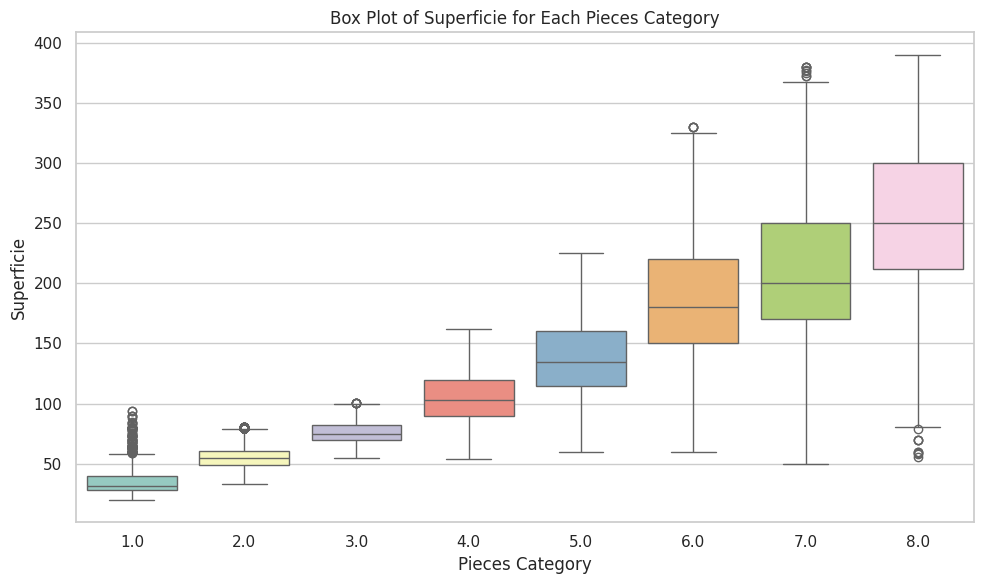

In [44]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(data=df, x='pieces', y='superficie', palette="Set3")

# Adding labels and title
plt.xlabel("Pieces Category")
plt.ylabel("Superficie")
plt.title("Box Plot of Superficie for Each Pieces Category")

# Show the plot
plt.tight_layout()
plt.show()

In [45]:
def iterative_outlier_cleaning(df):
    """
    Iteratively cleans the dataframe by handling 'superficie' outliers for each 'pieces' category.
    Continues until no more outliers are detected.
    
    Args:
    - df (pd.DataFrame): The dataframe to be cleaned.
    
    Returns:
    - pd.DataFrame: The cleaned dataframe.
    """
    while True:
        # Compute the IQR bounds for each 'pieces' category
        outlier_bounds = df.groupby('pieces').apply(calculate_bounds_1x).reset_index(name='bounds')
        outlier_bounds[['lower_bound', 'upper_bound']] = pd.DataFrame(outlier_bounds['bounds'].tolist(), index=outlier_bounds.index)
        outlier_bounds.drop(columns=['bounds'], inplace=True)

        # Join the bounds to the main dataframe
        df = pd.merge(df, outlier_bounds, on='pieces', how='left')

        # Identify rows with outliers
        outlier_mask = (df['superficie'] < df['lower_bound']) | (df['superficie'] > df['upper_bound'])
        outliers = df[outlier_mask]

        # If no outliers are found, exit the loop
        if outliers.shape[0] == 0:
            break
        
        # For rows with outliers, determine the possible categories based on IQR bounds
        for idx, row in outliers.iterrows():
            matching_categories = outlier_bounds[
                (outlier_bounds['lower_bound'] <= row['superficie']) &
                (outlier_bounds['upper_bound'] >= row['superficie'])
            ]['pieces'].values
            
            # If the 'superficie' matches multiple categories, choose the one with the closest median
            if len(matching_categories) > 1:
                chosen_category = min(matching_categories, key=lambda cat: abs(medians[cat] - row['superficie']))
                df.at[idx, 'pieces'] = chosen_category
            elif len(matching_categories) == 1:
                df.at[idx, 'pieces'] = matching_categories[0]
            else:
                df.at[idx, 'superficie'] = None  # Mark for deletion

        # Drop rows marked for deletion
        df.dropna(subset=['superficie'], inplace=True)
        df.drop(columns=['lower_bound', 'upper_bound'], inplace=True)
        df.reset_index(drop=True, inplace=True)
    
    return df

# Precompute the medians for each category before calling the function
medians = df.groupby('pieces')['superficie'].median()

# Apply the function
df = iterative_outlier_cleaning(df)


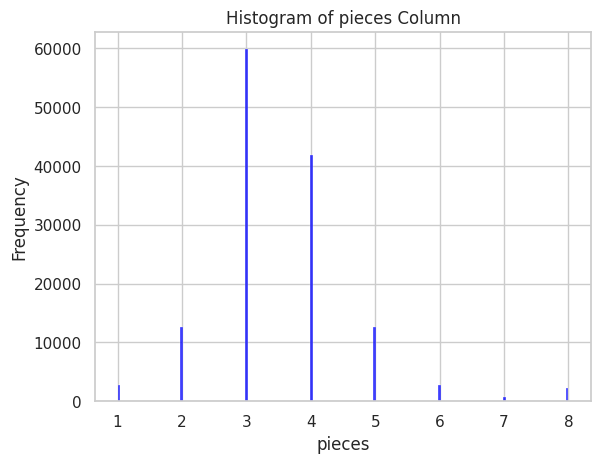

In [46]:
# Create a histogram using Seaborn
sns.histplot(data=df, x='pieces', kde=False, color='blue')
plt.xlabel('pieces')
plt.ylabel('Frequency')
plt.title('Histogram of pieces Column')
plt.show()

### Transform the pieces column

In [47]:
# Create a mapping dictionary
category_mapping = {1.0: 1, 2.0: 1, 3.0: 2, 4.0:3, 5.0:3, 6.0:3, 7.0:3, 8.0:3}

# Replace values in the 'piece' column using the mapping
df['pieces'] = df['pieces'].replace(category_mapping)

## Clean the price column

In [48]:
df_2 = df.copy()

In [49]:
# Create 'price_per_meter' column
df_2['price_per_meter'] = df_2['prdx_price'] / df_2['superficie']

# Define the bounds for each stt_name group
bounds = {
    'default': {'upper': 120000, 'lower': 40000},
    'Algiers': {'upper': 500000, 'lower': 80000},
    'specific_cities': {
        'names': [
            'oran', 'boumerdes', 'blida', 'tipaza', 'tizi ouzou', 'annaba', 
            'constantine', 'bejaia', 'setif', 'sidi bel abbes','Jijel'
        ],
        'upper': 190000,
        'lower': 60000
    }
}

def adjust_value_limited(row):
    #Adjust the price_per_meter value based on the rules provided, with limited iterations.
    stt = row['stt_name'].lower()
    
    # Determine the bounds for the current row
    if stt == 'algiers':
        upper_bound = bounds['Algiers']['upper']
        lower_bound = bounds['Algiers']['lower']
    elif stt in bounds['specific_cities']['names']:
        upper_bound = bounds['specific_cities']['upper']
        lower_bound = bounds['specific_cities']['lower']
    else:
        upper_bound = bounds['default']['upper']
        lower_bound = bounds['default']['lower']

    # Adjust the value with a maximum of 10 iterations to prevent infinite loops
    val = row['price_per_meter']
    original_val = val
    iterations = 0
    max_iterations = 10000000
    while ((val > upper_bound) or (val < lower_bound)) and iterations < max_iterations:
        if val > upper_bound:
            val /= 10
        elif val < lower_bound:
            val *= 10

        # If value shifts from one boundary to the other, mark for deletion
        if (original_val > upper_bound and val < lower_bound) or (original_val < lower_bound and val > upper_bound):
            return None

        iterations += 1

    return val

# Apply the function to adjust values
df_2['price_per_meter'] = df_2.apply(adjust_value_limited, axis=1)

# Remove rows with None values in 'price_per_meter'
df_2 = df_2.dropna(subset=['price_per_meter'])

# Remove rows with 'superficie' value of 0
#price_df = price_df[price_df['superficie'] != 0]

# Filter out any rows with NaN or inf values in 'price_per_meter'
df_2 = df_2[np.isfinite(df_2['price_per_meter'])]

# Round the values in 'price_per_meter' to the nearest integer
df_2['price_per_meter'] = df_2['price_per_meter'].round(0).astype(int)

In [51]:
# Custom rounding function
def custom_round(n):
    if n == 0:
        return 0
    # Determine the magnitude of the number
    magnitude = 10 ** (len(str(n)) - 2)
    return round(n/magnitude) * magnitude

# Apply the custom rounding function to the 'numbers' column
df_2['price_per_meter'] = df_2['price_per_meter'].apply(custom_round)

In [52]:
df_2 = df_2[['pieces','etages','superficie','prdx_price','asset_in_promotional_site','adr_longitude','adr_latitude','cty_name','stt_name','kitchen', 'heating', 'secured',
     'parking', 'garden', 'fournished', 'ownership','price_per_meter']]

### Drop the price_per_meter outliers

In [53]:
df_2 = df_2 [(df_2['price_per_meter'] <= 340000)]

def modified_drop_outliers(group):
    unique_prices = group['price_per_meter'].nunique()
    
    # If the group has only one or two unique 'price_per_meter' values, keep all records
    if unique_prices <= 2:
        return group
    
    Q1 = group['price_per_meter'].quantile(0.45)
    Q3 = group['price_per_meter'].quantile(0.85)
    lower_bound = Q1
    upper_bound = Q3
    
    return group[(group['price_per_meter'] >= lower_bound) & (group['price_per_meter'] <= upper_bound)]

# Apply the modified function to each group and concatenate the results
df_2 = df_2.groupby(['adr_latitude', 'adr_longitude']).apply(modified_drop_outliers).reset_index(drop=True)

# Check the number of unique groups after applying the modified function
len(df_2.groupby(['adr_latitude', 'adr_longitude']).size().reset_index(name='count'))

15272

In [54]:
#df_2['log_price_per_meter'] = np.log1p(df_2['price_per_meter'])

## Drop the groups that has more that has IQR greater than 800,000

In [ ]:
# Calculate IQR for each group
def calculate_iqr(group):
    Q1 = group['price_per_meter'].quantile(0)
    Q3 = group['price_per_meter'].quantile(1)
    IQR = Q3 - Q1
    return pd.Series({'IQR': IQR})

# Calculate IQR for each group and reset index
iqr_df = df_2.groupby(['adr_latitude', 'adr_longitude']).apply(calculate_iqr).reset_index()

# Filter out groups where IQR is greater than 100,000
filtered_iqr_df = iqr_df[iqr_df['IQR'] <= 80000]

# Merge the filtered IQR data back into the original DataFrame
df_2 = pd.merge(df_2, filtered_iqr_df[['adr_latitude', 'adr_longitude']], on=['adr_latitude', 'adr_longitude'], how='inner')

In [ ]:
len(df_2.groupby(['adr_latitude', 'adr_longitude']).size().reset_index(name='count'))

In [ ]:
df_2.dropna(inplace=True)

## Add impot data

In [62]:
final_villages_df = pd.read_csv('final_commune_with_prices_10_28.csv')

In [63]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
from shapely.geometry import Point, Polygon, MultiPolygon
from rapidfuzz import process, fuzz

def convert_to_geometry(data):
    try:
        return shapely.wkt.loads(data)
    except Exception as e:
        # Return an empty Point geometry if conversion fails
        return shapely.geometry.Point()


def filter_uuuuu_by_stt_name(stt_name, df, threshold=80):
    unique_stt_names = df['stt_name'].str.lower().unique()
    
    # Using rapidfuzz's process.extract
    matches = process.extract(stt_name.lower(), unique_stt_names, scorer=fuzz.WRatio, limit=None, score_cutoff=threshold)
    
    if matches:
        best_match = matches[0][0]  # Choose the best match (the one with the highest score)
        return df[df['stt_name'].str.lower() == best_match.lower()]
    else:
        return pd.DataFrame()


def calculate_rapports(row):
    centre_mean = (row['centre_min'] + row['centre_max']) / 2
    peripherique_mean = (row['peripherique_min'] + row['peripherique_max']) / 2
    far_mean = (row['far_min'] + row['far_max']) / 2

    rapport_centre_min = row['centre_min'] / centre_mean if (not np.isnan(row['centre_min']) and centre_mean != 0) else np.nan
    rapport_centre_max = row['centre_max'] / centre_mean if (not np.isnan(row['centre_max']) and centre_mean != 0) else np.nan
    rapport_peripherique_min = row['peripherique_min'] / peripherique_mean if (not np.isnan(row['peripherique_min']) and peripherique_mean != 0) else np.nan
    rapport_peripherique_max = row['peripherique_max'] / peripherique_mean if (not np.isnan(row['peripherique_max']) and peripherique_mean != 0) else np.nan
    rapport_far_min = row['far_min'] / far_mean if (not np.isnan(row['far_min']) and far_mean != 0) else np.nan
    rapport_far_max = row['far_max'] / far_mean if (not np.isnan(row['far_max']) and far_mean != 0) else np.nan

    return pd.Series({
        'rapport_centre_min': rapport_centre_min,
        'rapport_centre_max': rapport_centre_max,
        'rapport_peripherique_min': rapport_peripherique_min,
        'rapport_peripherique_max': rapport_peripherique_max,
        'rapport_far_min': rapport_far_min,
        'rapport_far_max': rapport_far_max
    })



def generate_random_points_within_polygon(polygon, num_points=5):
    if polygon.is_empty:
        print("Skipped empty polygon.")
        return []
    
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if random_point.within(polygon):
            points.append(random_point)
    
    return points

def correct_invalid_geometry(geometry):
    """Corrects an invalid geometry using a buffer trick."""
    if not geometry.is_valid:
        return geometry.buffer(0)
    return geometry

def handle_nan_values(row):
    # Fallback logic for NaN values
    if np.isnan(row['far_min']) or np.isnan(row['far_max']):
        if np.isnan(row['peripherique_min']) or np.isnan(row['peripherique_max']):
            row['far_min'] = row['centre_min']
            row['far_max'] = row['centre_max']
        else:
            row['far_min'] = row['peripherique_min']
            row['far_max'] = row['peripherique_max']
    return row

def generate_and_append_points_with_price(geometry, stt_name, commune_name, min_price, max_price, data_list):
    points = generate_random_points_within_polygon(geometry)
    for point in points:
        random_price = np.random.uniform(min_price, max_price) if not np.isnan(min_price) and not np.isnan(max_price) else np.nan
        data_list.append({
            'stt_name': stt_name,
            'commune_name': commune_name,
            'latitude': point.y,
            'longitude': point.x,
            'price': random_price
        })

def generate_points_with_pricing_logic(row, stt_name, commune_name, mean_price, rapports, data_list):
    if not np.isnan(mean_price):
        # For center
        generate_and_append_points_with_price(row['center'], stt_name, commune_name, 
                                              mean_price * rapports['rapport_centre_min'], mean_price * rapports['rapport_centre_max'], data_list)
        
        # For peripherique
        peripherique_geometry = correct_invalid_geometry(row['peripherique']).difference(correct_invalid_geometry(row['center']))
        generate_and_append_points_with_price(peripherique_geometry, stt_name, commune_name, 
                                              mean_price * rapports['rapport_peripherique_min'], mean_price * rapports['rapport_peripherique_max'], data_list)
        
        # For far
        far_geometry = correct_invalid_geometry(row['geometry']).difference(correct_invalid_geometry(row['peripherique']))
        generate_and_append_points_with_price(far_geometry, stt_name, commune_name, 
                                              mean_price * rapports['rapport_far_min'], mean_price * rapports['rapport_far_max'], data_list)
    else:
        # Use specified min and max values when mean_price is NaN
        generate_and_append_points_with_price(row['center'], stt_name, commune_name, 
                                              row['centre_min'], row['centre_max'], data_list)
        
        peripherique_geometry = correct_invalid_geometry(row['peripherique']).difference(correct_invalid_geometry(row['center']))
        generate_and_append_points_with_price(peripherique_geometry, stt_name, commune_name, 
                                              row['peripherique_min'], row['peripherique_max'], data_list)
        
        far_geometry = correct_invalid_geometry(row['geometry']).difference(correct_invalid_geometry(row['peripherique']))
        generate_and_append_points_with_price(far_geometry, stt_name, commune_name, 
                                              row['far_min'], row['far_max'], data_list)

# Assuming final_villages_df, s (uuuuu DataFrame) are already defined
# New logic begins here
# New logic begins here
final_villages_df['geometry'] = final_villages_df['geometry'].apply(convert_to_geometry)
final_villages_df['center'] = final_villages_df['center'].apply(convert_to_geometry)
final_villages_df['peripherique'] = final_villages_df['peripherique'].apply(convert_to_geometry)

generated_points_data = []

for stt_name in final_villages_df['stt_name'].str.lower().unique():
    # Filter data_df using fuzzy search for stt_name
    filtered_data_df = filter_uuuuu_by_stt_name(stt_name.lower(), df_2)  # Assuming s is defined and is the data_df

    # Filter reference_df for the current stt_name
    filtered_reference_df = final_villages_df[final_villages_df['stt_name'].str.lower() == stt_name.lower()]

    for _, row in filtered_reference_df.iterrows():
        commune_name = row['commune_name']  # Assuming 'commune_name' is the column name in reference_df

        if not filtered_data_df.empty:
            # Check if commune_name is in the filtered data_df
            if commune_name.lower() in filtered_data_df['cty_name'].str.lower().values:
                if len(filtered_data_df[filtered_data_df['cty_name'].str.lower() == commune_name.lower()]) <= 5:
                    mean_price = filtered_data_df['price_per_meter'].mean() if commune_name in filtered_data_df['cty_name'].values else np.nan
                    rapports = calculate_rapports(row)
                    generate_points_with_pricing_logic(row, stt_name, commune_name, mean_price, rapports, generated_points_data)
                else:
                    # Skip if count is more than 5
                    pass
            else:
                # If commune_name is not in cty_name
                row = handle_nan_values(row)
                generate_points_with_pricing_logic(row, stt_name, commune_name, np.nan, None, generated_points_data)
        else:
            # If filtered_data_df is empty (stt_name not in s)
            row = handle_nan_values(row)
            generate_points_with_pricing_logic(row, stt_name, commune_name, np.nan, None, generated_points_data)

generated_points_df = pd.DataFrame(generated_points_data)


Skipped empty polygon.


In [64]:
generated_points_df =  generated_points_df.dropna()

In [65]:
generated_points_df.columns = generated_points_df.columns.str.replace('commune_name', 'cty_name')
generated_points_df.columns = generated_points_df.columns.str.replace('latitude', 'adr_latitude')
generated_points_df.columns = generated_points_df.columns.str.replace('longitude', 'adr_longitude')
generated_points_df.columns = generated_points_df.columns.str.replace('price', 'price_per_meter')
generated_points_df = generated_points_df[['cty_name', 'adr_latitude', 'adr_longitude', 'stt_name','price_per_meter']]

### Keep only the needed columns

In [60]:
#df_2 = df_2[[ 'pieces', 'etages', 
#       'adr_longitude', 'adr_latitude', 'cty_name', 'cty_2008_population',
#       'cty_area', 'stt_id', 'stt_name',
#        'kitchen', 'heating',
#       'secured', 'parking', 'garden', 'fournished', 'ownership'
#       , 'price_per_meter']]

## Copy the df_2 to not make changes to it.

In [56]:
df_3=df_2.copy()

In [57]:
# Check data types
#print(df.dtypes)

# Example of converting a column to numeric
# Replace 'etages' with the appropriate column name
# and ensure the conversion is suitable for your data
df_3['etages'] = pd.to_numeric(df_3['etages'])

# Alternatively, for categorical data, use


In [58]:
df_3 = df_3[[ 'pieces', 'etages', 
       'adr_longitude', 'adr_latitude', 'cty_name', 'stt_name',
        'kitchen', 'heating',
       'secured', 'parking', 'garden', 'fournished'
       , 'price_per_meter']]

In [66]:
from sklearn.model_selection import train_test_split

single_occurrence_cities = df_3['cty_name'].value_counts()[df_3['cty_name'].value_counts() == 1].index

# Filter out rows with those city names and store them separately
single_occurrence_data = df_3[df_3['cty_name'].isin(single_occurrence_cities)]
df_3 = df_3[~df_3['cty_name'].isin(single_occurrence_cities)]

# Splitting the remaining data into training and testing sets using 'cty_name' for stratification
X = df_3.drop(columns=['price_per_meter'])
y = df_3['price_per_meter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['cty_name'], random_state=42, shuffle=True)


# Add single-occurrence data to the training data
X_train = pd.concat([X_train, single_occurrence_data.drop(columns=['price_per_meter'])], ignore_index=True)
y_train = pd.concat([y_train, single_occurrence_data['price_per_meter']], ignore_index=True)

X_train = pd.concat([X_train, generated_points_df.drop(columns=['price_per_meter'])], ignore_index=True)
y_train = pd.concat([y_train, generated_points_df['price_per_meter']], ignore_index=True)
# Create X_test_algiers and y_test_algiers

#X_test_algiers = X_test[X_test['stt_name'] == 'Algiers']
#y_test_algiers = y_test.loc[X_test_algiers.index]
# Get the indices of X_test_algiers and X_test_no_algiers
# Create X_test_no_algiers and y_test_no_algiers
#X_test_no_algiers = X_test[X_test['stt_name'] != 'Algiers']
#y_test_no_algiers = y_test.loc[X_test_no_algiers.index]

#X_test_no_algiers = X_test_no_algiers.drop(columns=['cty_name'])
#X_test_algiers = X_test_algiers.drop(columns=['cty_name'])
#X_test_no_algiers = X_test_no_algiers.drop(columns=['stt_name'])
#X_test_algiers = X_test_algiers.drop(columns=['stt_name'])
X_train = X_train.drop(columns=['cty_name'])
X_test = X_test.drop(columns=['cty_name'])
X_train = X_train.drop(columns=['stt_name'])
X_test = X_test.drop(columns=['stt_name'])

## Train the first model (with features)

In [ ]:
import optuna
import mlflow
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# Check if the 'sales_apartments' experiment exists, if not create it
experiment_name = 'sales_apartments'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
    
# Set the experiment to the one we're working on
mlflow.set_experiment(experiment_name)


def objective(trial):
    param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 350, 500),
        'max_depth': trial.suggest_int('max_depth', 15, 22),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
    }
    model = LGBMRegressor(**param)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

# Get the best parameters
best_params = study.best_params

# Train your model with the best parameters
lgb_model_best = LGBMRegressor(**best_params, random_state=42)
lgb_model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgb_model_best.predict(X_test)
y_pred_train = lgb_model_best.predict(X_train)


# Calculate the metrics

# Calculate the metrics
# Ensure these metrics calculations do not throw any errors
train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = train_mse ** 0.5
train_rrmse = train_rmse / np.mean(y_train) if np.mean(y_train) != 0 else None
train_rmsre = np.sqrt(np.mean(((y_pred_train - y_train) / y_train) ** 2)) if np.any(y_train) != 0 else None
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5
test_rrmse = train_rmse / np.mean(y_test) if np.mean(y_test) != 0 else None
test_rmsre = np.sqrt(np.mean(((y_pred - y_test) / y_test) ** 2)) if np.any(y_test) != 0 else None

# Start a new run
with mlflow.start_run():
    # Log the parameters of your model
    mlflow.log_params(lgb_model_best.get_params())
    
    # Log the list of feature names
    mlflow.log_param("feature_names", ", ".join(X_train.columns))

    # Log the metrics one by one
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_rrmse", train_rrmse)
    mlflow.log_metric("train_rmsre", train_rmsre)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_rrmse", test_rrmse)
    mlflow.log_metric("test_rmsre", test_rmsre)

    # Ensure cv_r2_scores is calculated and defined before this point
    # mlflow.log_metric("cv_mean_r2", cv_r2_scores.mean())
    # mlflow.log_metric("cv_std_r2", cv_r2_scores.std())

    # Log the model as an artifact
    mlflow.lightgbm.log_model(lgb_model_best, "model")

In [111]:
print(mlflow.get_tracking_uri())

file:///home/zaki/Desktop/H/mlruns


In [358]:
best_params

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'num_leaves': 63}

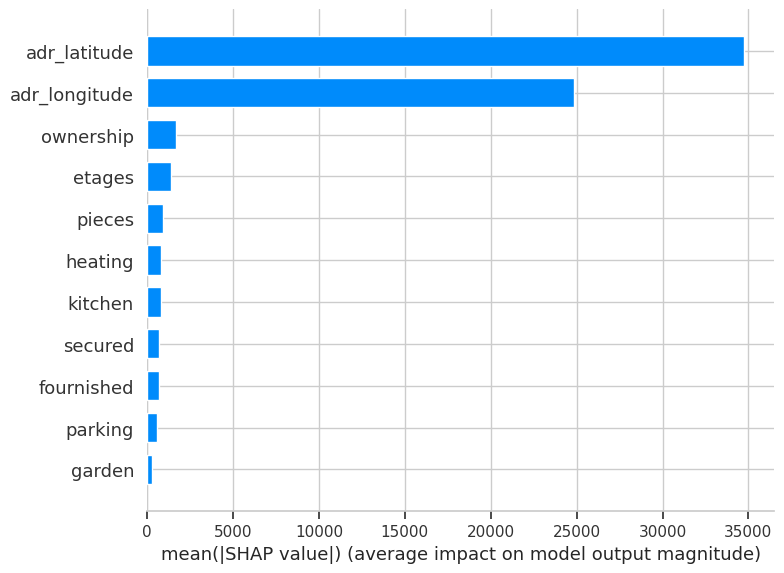

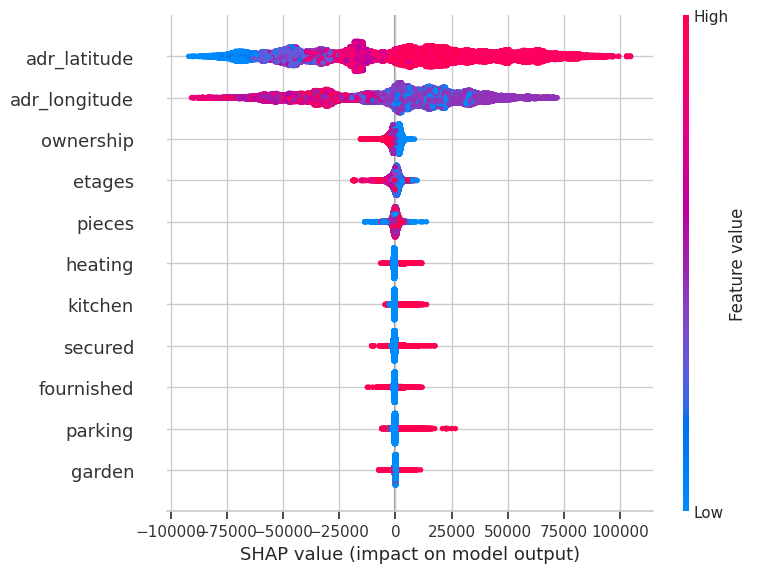

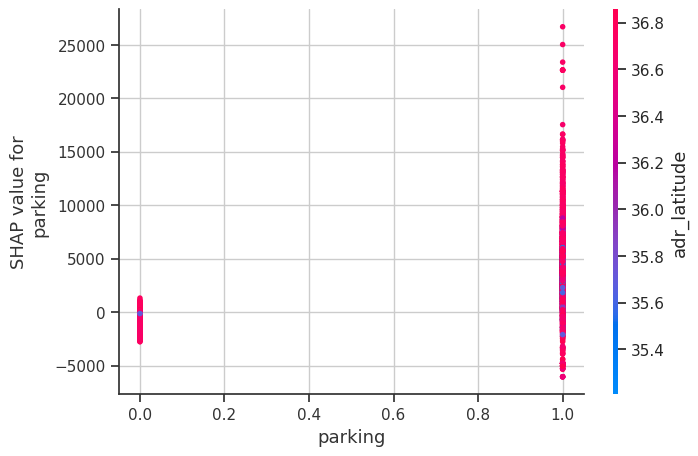

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 41572, number of used features: 11
[LightGBM] [Info] Start training from score 151760.247282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

In [360]:
import shap

# Assuming lgb_model is your trained LightGBM model and X_train is your training dataset

# Create the SHAP Explainer
explainer = shap.TreeExplainer(lgb_model_best)
shap_values = explainer.shap_values(X_train)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar")

# For a more detailed summary plot that shows the impact of each feature on each sample
shap.summary_plot(shap_values, X_train)

# To plot SHAP values for a single feature (e.g., 'feature_name')
shap.dependence_plot('parking', shap_values, X_train)


#### Plot the residuals

In [ ]:

# Calculate the residuals
residuals = y_test - y_pred  # Calculate the residuals by subtracting predictions from actual values

# Create a histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals for algiers')
plt.show()

In [ ]:
# Calculate the residuals
residuals = y_test - y_pred  # Calculate the residuals by subtracting predictions from actual values

# Create a histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals for algiers')
plt.show()

## Train the model with geo only

In [133]:
from sklearn.model_selection import GridSearchCV
import mlflow
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

# Check if the 'sales_apartments' experiment exists, if not create it
experiment_name = 'sales_apartments'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
    
# Set the experiment to the one we're working on
mlflow.set_experiment(experiment_name)

X_train_geo = X_train[['adr_latitude', 'adr_longitude']]
X_test_geo = X_test[['adr_latitude', 'adr_longitude']]

# Define your model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [5, 7, 9,12],  # You can adjust these values and add more
    'num_leaves': [15, 31, 40,63],  # Adjust these values based on max_depth
    'learning_rate': [0.01, 0.05, 0.1,0.2],  # Example values
    'n_estimators': [350,400,450, 500]  # Example values
}

# Setup the grid search
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=2,force_row_wise=True)

# Perform the grid search
grid_search.fit(X_train_latlong, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train your model with the best parameters
lgb_model_best_2 = lgb.LGBMRegressor(**best_params, random_state=42)
lgb_model_best_2.fit(X_train_geo, y_train)


# Make predictions on the test set
y_pred = lgb_model_best_2.predict(X_test_geo)
y_pred_train = lgb_model_best_2.predict(X_train_geo)

# Calculate the metrics

train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = train_mse ** 0.5
train_rrmse = train_rmse / np.mean(y_train)    
train_rmsre = np.sqrt(np.mean(((y_pred_train - y_train) / y_train) ** 2))
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5
test_rrmse = train_rmse / np.mean(y_test)    
test_rmsre = np.sqrt(np.mean(((y_pred - y_test) / y_test) ** 2))


# Start a new run
with mlflow.start_run():
    # Log the parameters of your model
    mlflow.log_params(lgb_model_best_2.get_params())
    # Log the list of feature names
    mlflow.log_param("feature_names", ", ".join(X_train.columns))
    # Log the metrics one by one
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_rrmse", train_rrmse)
    mlflow.log_metric("train_rmsre", train_rmsre)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_rrmse", test_rrmse)
    mlflow.log_metric("test_rmsre", test_rmsre)

    
    # Log the model as an artifact (as you already have)
    mlflow.lightgbm.log_model(lgb_model_best_2, "model")

/home/zaki/Desktop/transcription/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/zaki/Desktop/transcription/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [120]:
#import bentoml
#bentoml.lightgbm.save_model("sel_lightgbm_45-85",lgb_model)

Model(tag="sel_lightgbm_45-85:d4hqzbtwi6eo47iu", path="/home/zaki/bentoml/models/sel_lightgbm_45-85/d4hqzbtwi6eo47iu/")

In [63]:
#model = bentoml.lightgbm.load_model("sel_lightgbm_45-85:rxculms26gpxt4po")

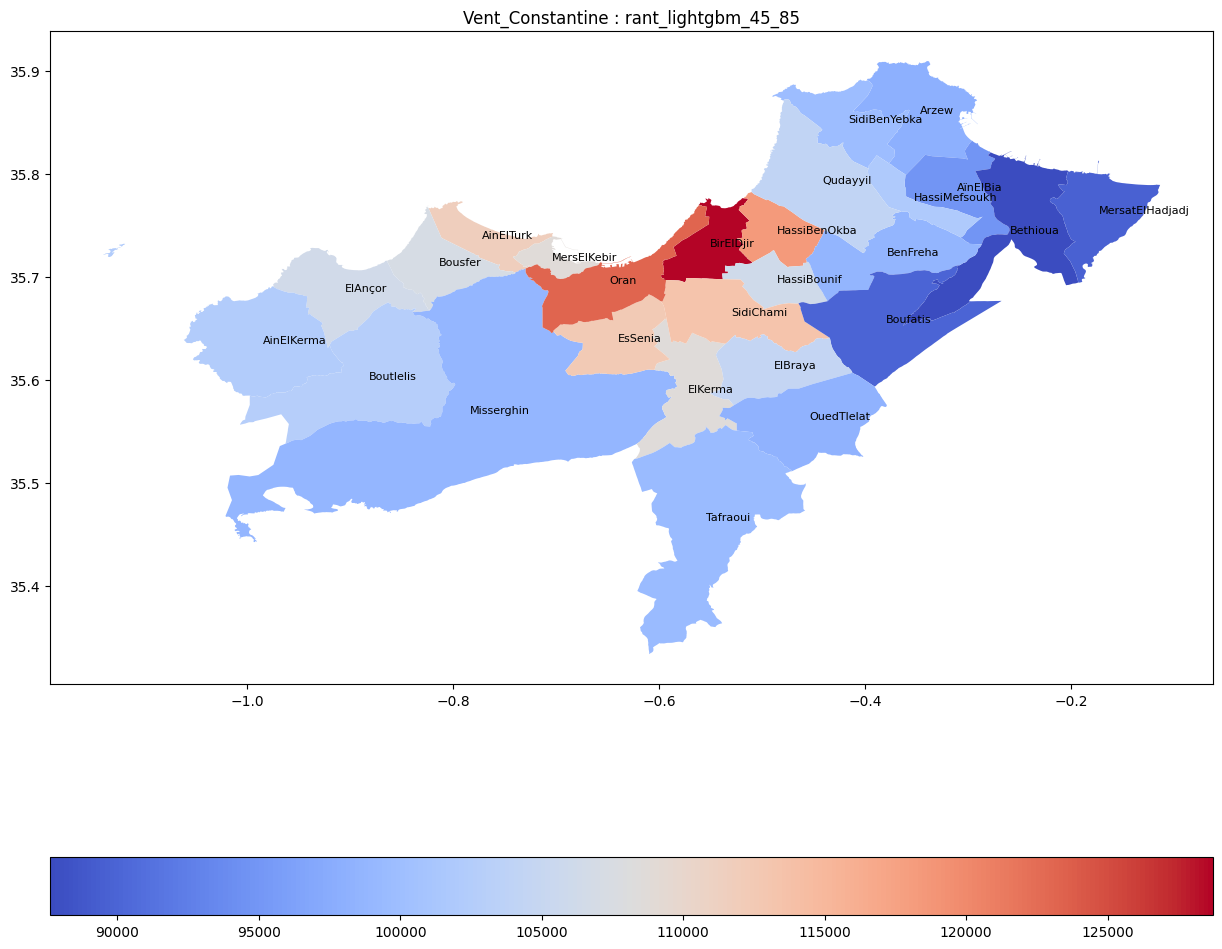

In [72]:
import pandas as pd
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load GeoJSON data models/Cities/
with open("models/Cities/Oran.json", "r") as file:
    geojson_data = json.load(file)
features = [{'type': 'Feature', 'properties': {'name': name}, 'geometry': data} 
            for name, data in geojson_data.items()]
gdf = gpd.GeoDataFrame.from_features(features)

# Generate random points within a given polygon
def generate_random_points_within_polygon(polygon, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if random_point.within(polygon):
            points.append(random_point)
    return points

# Generate predictions and compute means for each province
province_means = {}
for _, row in gdf.iterrows():
    province_name = row['name']
    province_geometry = row['geometry']
    random_points = generate_random_points_within_polygon(province_geometry, 3000)
    coords = np.array([(point.y, point.x) for point in random_points])
    predictions = lgb_model.predict(coords)
    province_means[province_name] = predictions.mean()

# Add mean predictions to GeoDataFrame
gdf['mean_prediction'] = gdf['name'].map(province_means)

# Plot the map with province names and mean predictions
fig, ax = plt.subplots(figsize=(15, 15))

gdf.plot(column='mean_prediction', cmap='coolwarm', legend=True, ax=ax,  legend_kwds={'orientation': 'horizontal'})
# Add province names as labels
for _, row in gdf.iterrows():
    ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['name'], fontsize=8)
ax.set_title('Vent_Constantine : rant_lightgbm_45_85')
plt.show()

In [512]:
df_2[df_2['cty_name']=='Bir el arch']

,cty_name,adr_latitude,adr_longitude,stt_name,price_per_meter


In [ ]:
import folium
from folium.plugins import MarkerCluster

# Identifying city names that appear only once
# Create a base map
m_5 = folium.Map(location=[30.49941087260372, 2.50439793032094], tiles='cartodbpositron', zoom_start=6)

# Create a MarkerCluster layer
marker_cluster = MarkerCluster().add_to(m_5)

# Iterate through the dataframe rows
for index, row in df_3.iterrows():
    popup_html = f"""
    <b>Price/meter:</b> {row['price_per_meter']:.2f}<br>
    <b>Superficie:</b> {row['superficie']}<br>
    <b>Prdx_price:</b> {row['prdx_price']}<br>
    <b>Pieces:</b> {row['price']}<br>
    <b>Address_name:</b> {row['adr_address_01']}<br>
    <b>Cty_name:</b> {row['cty_name']}<br>
    <b>Stt_name:</b> {row['stt_name']}<br>
    <b>Request_id:</b> {row['address_request_id']}<br>

    """
    
    folium.CircleMarker(
        location=[row['adr_latitude'], row['adr_longitude']],
        radius=5,
        color='blue',  # You can change the color
        fill=True,
        fill_color='blue',  # You can change the fill color
        fill_opacity=0.7,
        popup=folium.Popup(html=popup_html, max_width=300)  # Set max_width for popup
    ).add_to(marker_cluster)

# Display the map
m_5

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Check if the 'sales_apartments' experiment exists, if not create it
experiment_name = 'sales_apartments'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
    
# Set the experiment to the one we're working on
mlflow.set_experiment(experiment_name)

# Make predictions on the test set
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=30,weights='uniform')
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
# Calculate the metrics
train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = train_mse ** 0.5
train_rrmse = train_rmse / np.mean(y_train)    
train_rmsre = np.sqrt(np.mean(((y_pred_train - y_train) / y_train) ** 2))
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5
test_rrmse = train_rmse / np.mean(y_test)    
test_rmsre = np.sqrt(np.mean(((y_pred - y_test) / y_test) ** 2))


# Start a new run
with mlflow.start_run():
    # Log the parameters of your model
    mlflow.log_params(knn.get_params())

    # Log the metrics one by one
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_rrmse", train_rrmse)
    mlflow.log_metric("train_rmsre", train_rmsre)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_rrmse", test_rrmse)
    mlflow.log_metric("test_rmsre", test_rmsre)

    # Log the model as an artifact
    mlflow.lightgbm.log_model(knn, "knn_model")

/home/zaki/Desktop/transcription/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/zaki/Desktop/transcription/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [116]:
knn.predict([[36.746364940834894, 3.0346702052759813]])

/home/zaki/Desktop/transcription/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([233374.35264527])

In [612]:
import mlflow
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error


# Check if the 'sales_apartments' experiment exists, if not create it
experiment_name = 'sales_apartments'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
    
# Set the experiment to the one we're working on
mlflow.set_experiment(experiment_name)

# Define and fit your model
cat_model = CatBoostRegressor(verbose=0,depth=10, iterations= 400, l2_leaf_reg= 3, learning_rate= 0.5)
cat_model.fit(X_train, y_train)  # Corrected the target variable

# Make predictions on the test set
y_pred = cat_model.predict(X_test)

# Calculate the metrics
train_r2 = r2_score(y_train, cat_model.predict(X_train))
train_mse = mean_squared_error(y_train, cat_model.predict(X_train))  # Corrected the prediction source
train_rmse = train_mse ** 0.5
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = test_mse ** 0.5


# Start a new run
with mlflow.start_run():
    # Log the parameters of your model
    mlflow.log_params(cat_model.get_params())
     # Log the list of feature names
    mlflow.log_param("feature_names", ", ".join(X_train.columns))
    # Log the metrics one by one
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)

    # Log the model as an artifact
    mlflow.lightgbm.log_model(cat_model, "model")

/home/zaki/Desktop/transcription/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

/home/zaki/Desktop/transcription/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.



In [108]:
cat_model.predict([[36.71913490887771, 3.205865543171459]])

array([235756.4764795])